In [1]:
import open3d as o3
import numpy as np
import pykitti
from tqdm import tqdm
import torch
import torch.nn.functional as F
from CMRNet.utils import (to_rotation_matrix, mat2xyzrpy, merge_inputs, overlay_imgs, quat2mat,
                   quaternion_from_matrix, rotate_back, rotate_forward,
                   tvector2mat)
from CMRNet.models.CMRNet.CMRNet import CMRNet
from CMRNet.camera_model import CameraModel
from torchvision import transforms
import visibility

#####################################################
# ORB Loading
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt

## Reading orb poses given by Harsh

In [2]:
def create_merged_df():
    orb_pose_df = pd.read_csv('./cam_tracking/data/orb_poses.csv')
    orb_pose_df = orb_pose_df.drop(columns=['rosbagTimestamp','Unnamed: 1', 'Unnamed: 2', 'seq','Unnamed: 8', 'transform','Unnamed: 13'])
    orb_pose_df = orb_pose_df[orb_pose_df['child_frame_id']=='"camera_link"']
    kitti_images_df_short = pd.read_csv('./cam_tracking/data/kitti_images_nodata.csv')
    merged_df = pd.merge(orb_pose_df,kitti_images_df_short,on=['nsecs','secs'])
    merged_df.to_csv('./cam_tracking/data/kitti_data_orb_poses.csv')

def process_original_kitti_df():
    kitti_images_df = pd.read_csv('./cam_tracking/data/kitti_images.csv')
    images_path = '../cam_tracking/data/images/*.jpg'
    images_files = glob(images_path)
    images_files.sort()
    kitti_images_df_short = kitti_images_df.drop(columns=['rosbagTimestamp','data','encoding','height','width','is_bigendian','step','header','seq','stamp'])
    kitti_images_df_short['files']=images_files
    kitti_images_df_short.to_csv('./cam_tracking/data/kitti_images_nodata.csv')

In [3]:
# psuedo code for reading the orbslam poses and corresponding uma
merged_df = pd.read_csv('./cam_tracking/data/kitti_data_orb_poses.csv')
## Read data of the sequence from a loop
for index, entry in merged_df.iterrows():
    imagepath = entry['files']
    image = cv2.imread(imagepath)
    orb_pose = entry[['x','y','z','qx','qy','qz','qw']].values
    t,q = orb_pose[:3],orb_pose[3:]
    break

## A Class to use CMRNet to refine poses

In [2]:
class RefineEstimate(object):
    """
    Functionality to refine an estimate of a pose
    using CMR Net
    """
    def __init__(self, config):
        path_to_dataset = config["path_to_dataset"] 
        path_to_map = config["path_to_map"]
        weight_paths = config["weight_paths"]
        sequence = config["sequence"]
        # setup kitti manager
        self.kitti = pykitti.odometry(path_to_dataset, sequence)
        # load the downsampled map
        full_map = o3.read_point_cloud(path_to_map)
        # convert map into torch tensor. this is (3,no of points) coordinates
        voxelized = torch.tensor(full_map.points, dtype=torch.float)
        # added a extra homogeneous cordinate
        voxelized = torch.cat((voxelized, torch.ones([voxelized.shape[0], 1], dtype=torch.float)), 1)
        voxelized = voxelized.t()
        voxelized = voxelized.to("cuda")
        # this containsthe intensities of each of this point
        vox_intensity = torch.tensor(full_map.colors, dtype=torch.float)[:, 0:1].t()
        velo2cam2 = torch.from_numpy(self.kitti.calib.T_cam2_velo).float().to("cuda")
        self.map = voxelized
        self.velo2cam = velo2cam2
        self.cam2velo = self.velo2cam.inverse()
        self.map_intensity = vox_intensity
        # load the models into a list
        self.image_shape = (384,1280)
        self.models = self.load_models(weight_paths)
        # initialize a camera model used to project lidar point cloud
        self.cam_params = self.get_calib_kitti(sequence).cuda()
        self.camera_model = CameraModel(focal_length=self.cam_params[:2], 
                                        principal_point=self.cam_params[2:])
    
    def get_calib_kitti(self, sequence):
        if sequence == '00':
            return torch.tensor([718.856, 718.856, 607.1928, 185.2157])
        elif sequence == '03':
            return torch.tensor([721.5377, 721.5377, 609.5593, 172.854])
        elif sequence in ['05', '06', '07', '08', '09']:
            return torch.tensor([707.0912, 707.0912, 601.8873, 183.1104])
        else:
            raise TypeError("Sequence Not Available")
            
    def load_models(self,weight_paths):
        """
        Loads the models stored in the paths sent.
        Args:
        weight_paths: A list of paths for the models
        Returns:
        A list of models
        """
        models = []
        for i, path in enumerate(weight_paths):
            model = CMRNet(self.image_shape, use_feat_from=1, md=4, use_reflectance=False)
            checkpoint = torch.load(path, map_location='cpu')
            saved_state_dict = checkpoint['state_dict']
            model.load_state_dict(saved_state_dict)
            model = model.to("cuda")
            model.eval()
            models.append(model)
            if i == 0:
                self.occlusion_th = checkpoint['config']['occlusion_threshold']
                self.occlusion_kernel = checkpoint['config']['occlusion_kernel']
        return models
    
    def project_and_crop_pc_into_cam_frame(self, camera_pose):
        """
        Projects the pointcloud into camera frame. 
        Selects points within the view of the camera and returns them.
        Args:
        camera_pose: A 4 X 4 transformation matrix SE3 that takes points in the camera coordinate frame to world frame
        Returns:
        projected_pc: a dict with points projected in camera frame and the relevant intensities
        """
        # compute the velodyne pose as a transformation matrix from this
        rot_mat_cam = torch.from_numpy(camera_pose).float()
        rot_mat_cam = rot_mat_cam.to("cuda")
        rot_mat_velo = torch.mm(self.cam2velo, rot_mat_cam.inverse())
        # transform the velodyne point cloud positions into the current velo dyne pose
        local_map = self.map.clone()
        local_intensity = self.map_intensity.clone()
        local_map = torch.mm(rot_mat_velo, local_map).t()
        # select indices within viewing range
        indexes = local_map[:, 1] > -25.
        indexes = indexes & (local_map[:, 1] < 25.)
        indexes = indexes & (local_map[:, 0] > -10.)
        indexes = indexes & (local_map[:, 0] < 100.)
        local_map = local_map[indexes]
        local_intensity = local_intensity[:, indexes]
        # convert the positions into camera frame
        local_map = torch.mm(self.velo2cam, local_map.t())
        local_map = local_map[[2, 0, 1, 3], :]
        projected_pc = {
            "positions": local_map,
            "intensities": local_intensity
        }
        return local_map
    
    def preprocess_image(self, image):
        """
        Preprocess image to feed into network
        """
        to_tensor = transforms.ToTensor()
        normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        
        image = to_tensor(image)
        image = normalization(image)
        return image
        
    def project_lidar(self, pc, image_shape, shape_pad):
        """
        Project the lidar point cloud into an 2D array
        """
        uv, depth, points, refl = self.camera_model.project_pytorch(pc, image_shape, None)
        uv = uv.t().int()
        depth_img = torch.zeros(image_shape[:2], device='cuda', dtype=torch.float)
        depth_img += 1000.
        depth_img = visibility.depth_image(uv, depth, depth_img, uv.shape[0], image_shape[1], image_shape[0])
        depth_img[depth_img == 1000.] = 0.
        projected_points = torch.zeros_like(depth_img, device='cuda')
        projected_points = visibility.visibility2(depth_img, self.cam_params, projected_points, depth_img.shape[1],
                                                      depth_img.shape[0], self.occlusion_th,
                                                      self.occlusion_kernel)
        projected_points /= 100.
        projected_points = projected_points.unsqueeze(0)
        projected_points = F.pad(projected_points, shape_pad)
        return projected_points
        
    def refine_pose_estimate(self, predicted_pose, image):
        """
        Get a refined estimate using CMRNet
        """
        processed_image = self.preprocess_image(image)
        image_shape = (processed_image.shape[1], processed_image.shape[2], processed_image.shape[0])
        processed_image = processed_image.cuda()
        shape_pad = [0, 0, 0, 0]
        shape_pad[3] = (self.image_shape[0] - processed_image.shape[1])
        shape_pad[1] = (self.image_shape[1] - processed_image.shape[2])
        processed_image = F.pad(processed_image, shape_pad)
        # project point cloud into 2D array
        local_pc_in_cam_frame = self.project_and_crop_pc_into_cam_frame(predicted_pose)
        pc_image = self.project_lidar(local_pc_in_cam_frame, image_shape, shape_pad)
        # iteratively refine
        RT_cumulative = torch.eye(4).cuda()
        images = []
        with torch.no_grad():
            for i, model in enumerate(self.models):
                T_predicted, R_predicted = model(processed_image.unsqueeze(0), pc_image.unsqueeze(0))
                R_predicted = quat2mat(R_predicted[0])
                T_predicted = tvector2mat(T_predicted[0])
                RT_predicted = torch.mm(T_predicted, R_predicted)
                RT_cumulative = torch.mm(RT_cumulative, RT_predicted)
                out3 = overlay_imgs(processed_image, pc_image.unsqueeze(0))
                local_pc_in_cam_frame = rotate_forward(local_pc_in_cam_frame, RT_predicted)
                pc_image = self.project_lidar(local_pc_in_cam_frame, image_shape, shape_pad)
                images.append(out3)
        return RT_cumulative, images

In [3]:
config = {
    "weight_paths": ['./CMRNet/checkpoints/iter1.tar','./CMRNet/checkpoints/iter2.tar','./CMRNet/checkpoints/iter3.tar'],
    "path_to_map": "./CMRNet/map-00_0.1_0-300.pcd",
    "path_to_dataset": "./CMRNet/KITTI_ODOMETRY",
    "sequence": "00"
}

ref = RefineEstimate(config)

Ground truth poses are not avaialble for sequence 00.


In [4]:
# Test this class functionality
kitti = pykitti.odometry("/home/arcot/Projects/SLAM_Project/dataset", "00")

In [19]:
pose1 = kitti.poses[100]
pose1[0,-1] += 1.5
pose1[1,-1] += 0.5
image = kitti.get_cam2(100)
pose, images = ref.refine_pose_estimate(pose1, image)
print(pose)

tensor([[ 1.0000,  0.0031, -0.0030, -0.6017],
        [-0.0031,  0.9999,  0.0168, -2.4701],
        [ 0.0031, -0.0168,  0.9999, -1.5560],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


<Figure size 432x288 with 0 Axes>

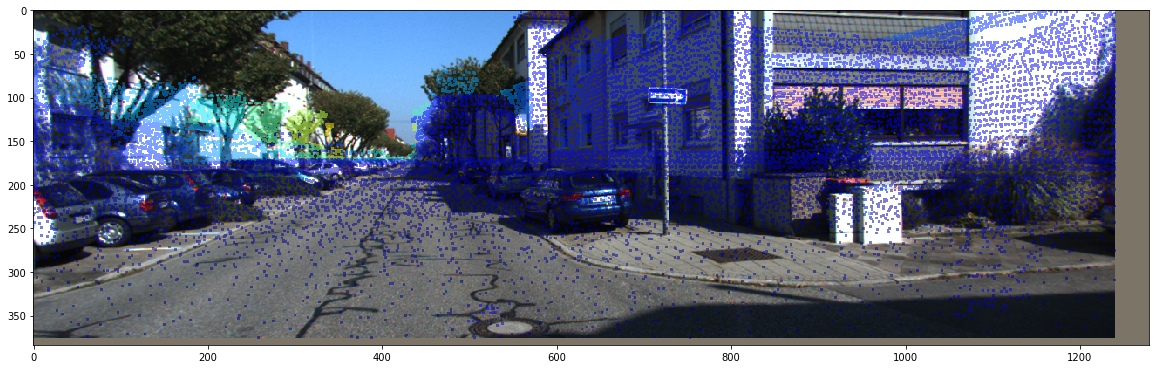

<Figure size 432x288 with 0 Axes>

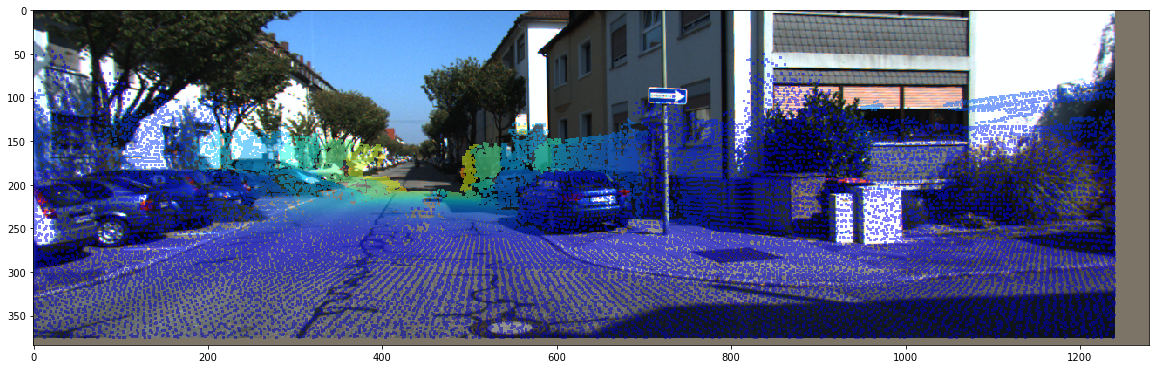

<Figure size 432x288 with 0 Axes>

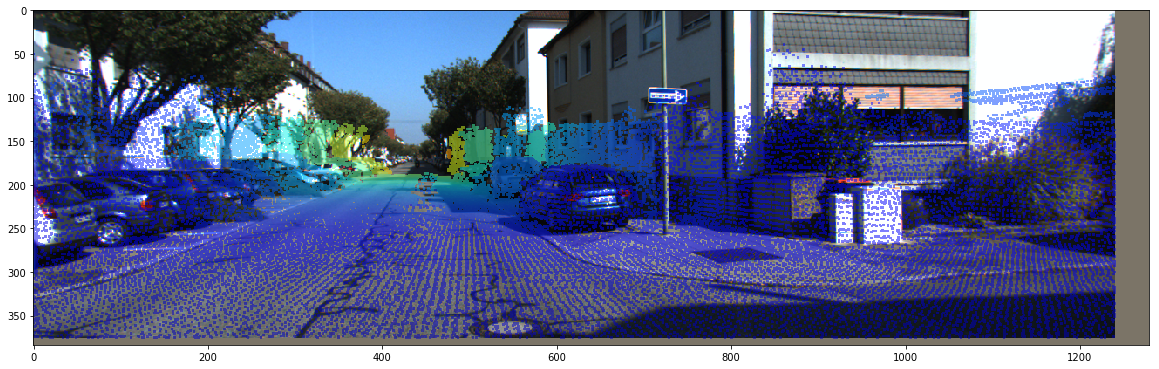

In [20]:
for i in range(len(images)):
    plt.figure()
    plt.figure(figsize=(20,10))
    plt.imshow(images[i])

In [23]:
predicted_pose = kitti.poses[10]
image = kitti.get_cam2(10)
processed_image = ref.preprocess_image(image)
image_shape = (processed_image.shape[1], processed_image.shape[2], processed_image.shape[0])
processed_image = processed_image.cuda()
shape_pad = [0, 0, 0, 0]
shape_pad[3] = (ref.image_shape[0] - processed_image.shape[1])
shape_pad[1] = (ref.image_shape[1] - processed_image.shape[2])
processed_image = F.pad(processed_image, shape_pad)
# project point cloud into 2D array
local_pc_in_cam_frame = ref.project_and_crop_pc_into_cam_frame(predicted_pose)
pc_image = ref.project_lidar(local_pc_in_cam_frame, image_shape, shape_pad)
# iteratively refine
RT_cumulative = torch.eye(4)
for i, model in enumerate(ref.models):
    T_predicted, R_predicted = model(processed_image, pc_image)
    R_predicted = quat2mat(R_predicted[0])
    T_predicted = tvector2mat(T_predicted[0])
    RT_predicted = torch.mm(T_predicted, R_predicted)
    RT_cumulative = torch.mm(RT_cumulative, RT_predicted)
    local_pc_in_cam_frame = rotate_forward(local_pc_in_cam_frame, RT_predicted)
    pc_image = ref.project_lidar(local_pc_in_cam_frame, image_shape, shape_pad)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 1, 3, 3], but got 3-dimensional input of size [1, 384, 1280] instead

In [24]:
processed_image.shape

torch.Size([1, 3, 757, 2145])

In [25]:
pc_image.shape

torch.Size([1, 384, 1280])

## Trying to figure out the transformation between CMRNet frame and the Kitti (T_world_camera_gray_left) frame

In [107]:
# Load the CMRNet frame poses
poses_cmrnet = []
pose_file = "./CMRNet/data/kitti-00.csv"
with open(pose_file, 'r') as f:
    for x in f:
        if x.startswith('timestamp'):
            continue
        x = x.split(',')
        T = torch.tensor([float(x[1]), float(x[2]), float(x[3])])
        R = torch.tensor([float(x[7]), float(x[4]), float(x[5]), float(x[6])])
        poses_cmrnet.append(to_rotation_matrix(R, T))

In [109]:
# Load the Kitti frame poses using pykitti
kitti = pykitti.odometry("/home/arcot/Projects/SLAM_Project/dataset", "00")

In [115]:
# Print the transformation between Kitti frame and CMRNet frame for 5 frames
for i in range(20):
    print("###############################")
    transformation = np.linalg.inv(kitti.poses[i]) @ poses_cmrnet[i].numpy()
    print(transformation)

###############################
[[ 9.98206079e-01  8.60046036e-03  5.92506826e-02  1.40773001e+01]
 [-1.27487797e-02  9.97465849e-01  6.99948741e-02  3.46362995e+00]
 [-5.84985524e-02 -7.06246941e-02  9.95786230e-01  3.25146021e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
###############################
[[ 9.98212809e-01  5.12786036e-03  5.95374482e-02  1.48746610e+01]
 [-9.21590082e-03  9.97602146e-01  6.85932224e-02  3.53074818e+00]
 [-5.90429589e-02 -6.90193403e-02  9.95866667e-01  3.15861792e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
###############################
[[ 9.98183617e-01  3.58237254e-04  6.02425088e-02  1.56799364e+01]
 [-4.59613138e-03  9.97520675e-01  7.02234028e-02  3.60334639e+00]
 [-6.00680062e-02 -7.03727404e-02  9.95710626e-01  3.06514960e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
###############################
[[ 9.98114866e-01 -4.29185469e-03  6.12230720e-02  1.65004730e+01

In [220]:
car_poses = []
for i in range(len(kitti.poses)):
#     car_poses.append([kitti.poses[i][0,-1], kitti.poses[i][2,-1]])
#     pose = np.linalg.inv(np.linalg.inv(kitti.calib.T_cam0_velo) @ np.linalg.inv(kitti.poses[i]))
    pose = kitti.poses[i] @ kitti.calib.T_cam0_velo
    car_poses.append([pose[0,-1], pose[2,-1]])

In [221]:
car_poses = np.array(car_poses)

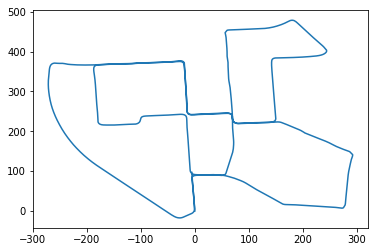

In [222]:
plt.plot(car_poses[:,0], car_poses[:,1])

In [232]:
car_poses_cmrnet = []
for i in range(len(poses_cmrnet)):
    pose = poses_cmrnet[i].numpy()
    car_poses_cmrnet.append([pose[0,-1], pose[1,-1]])
car_poses_cmrnet = np.array(car_poses_cmrnet)

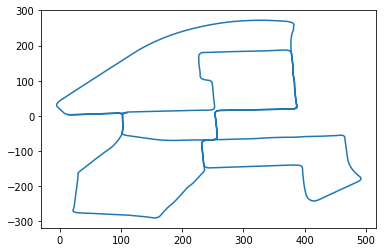

In [233]:
plt.plot(car_poses_cmrnet[:,0], car_poses_cmrnet[:,1])

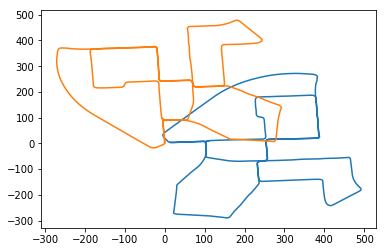

In [234]:
plt.plot(car_poses_cmrnet[:,0], car_poses_cmrnet[:,1])
plt.plot(car_poses[:,0], car_poses[:,1])

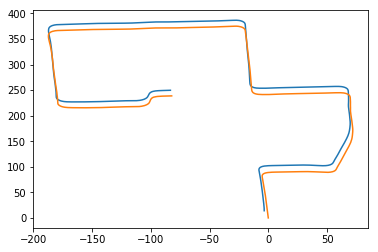

In [169]:
i = 1300
plt.plot(car_poses_cmrnet[:i,0], car_poses_cmrnet[:i,1])
plt.plot(car_poses[:i,0], car_poses[:i,1])